# REVES 02: Data Engineering

In this notebook, we will transform the data to fit the format required for our model and we will create new features to add valuable info to it. 

To start this notebook we will use the DataFrame we generated at the end of Cleaning_Data.

## Loading libraries and data

In [1]:
import pandas as pd
import revesFunctions as rf
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

In [2]:
reves = pd.read_pickle("data/cleaned_reves_df.pkl")

In [3]:
reves.head(2)

,directors,writers,belongs_to_collection,genres,original_language,production_companies,revenue,runtime,title,keywords,release_year,release_month,release_weekday,cast_names,cast_gender
0,[D.W. Griffith],"[Thomas Dixon Jr., D.W. Griffith, Frank E. Woods]",NaN,"[Drama, History, War]",en,[Epoch Film Co.],11000000.0,193.0,The Birth of a Nation,"[ku klux klan, southern usa, patriotism, army,...",1915.0,2.0,0.0,"[Lillian Gish, Mae Marsh, Henry B. Walthall, M...","[1, 1, 2, 1, 0, 2, 2, 1, 2, 1, 2, 2, 0, 0, 0, ..."
1,[Cecil B. DeMille],"[Hector Turnbull, Jeanie Macpherson]",NaN,[Drama],en,[Jesse L. Lasky Feature Play Company],137365.0,59.0,The Cheat,[],1915.0,12.0,0.0,"[Fannie Ward, Jack Dean, Sessue Hayakawa, Jame...","[1, 2, 2, 0, 0, 0, 0, 0, 0, 2, 2]"


## Let's perform some data transformation

#### Revenue & Release Year

First of all, we have to transform revenue. We ought to take notice that the ticket price has been changing through the years as well as money's price itself. We all know that it's way different if a movie reached a $100 million box office on 1930 than if a movie did it nowadays.

To to this engineering, we have transform revenue by applying a CPI-based factor. 

- Data has been collected from this website: https://www.usinflationcalculator.com/inflation/consumer-price-index-and-annual-percent-changes-from-1913-to-2008/

- You can find a better explanation of this idea here: https://www.usinflationcalculator.com/frequently-asked-questions-faqs/#HowInflationCalculatorWorks

Data has been downloaded as a CSV to use it with Pandas. Data transformations have been made up to 2017 and stored in a new column called revenue_inflated.

In [4]:
cpi_df = pd.read_excel("data/CPI_data.xlsx")
cpi_dict = dict(zip(cpi_df["Year"], cpi_df["Avg"]))
reves["cpi"] = reves["release_year"].apply(lambda x: cpi_dict[x] if x in cpi_dict else 0)
reves["revenue_inflated"] = reves["revenue"] * (cpi_dict[2017] / reves["cpi"])

In [5]:
reves[["revenue", "revenue_inflated", "release_year", "title"]].sort_values(by = "revenue_inflated", ascending = False).head(5)

,revenue,revenue_inflated,release_year,title
58,4.001765e+08,7.056925e+09,1939.0,Gone with the Wind
123,5.720000e+08,5.392640e+09,1951.0,Alice in Wonderland
75,2.674472e+08,4.021880e+09,1942.0,Bambi
4537,2.787965e+09,3.185399e+09,2009.0,Avatar
54,1.849255e+08,3.147843e+09,1937.0,Snow White and the Seven Dwarfs


#### Belongs to collection

As we stablished on the previews notebook, the fact that a movie does belong to a collection or franchise is directely related to potential revenue. We also could prove that some collection had higher incomes than others.

This is why we are performing a data transformation that consists on calculating average revenue per collection and applying this value to each movie, according to the current value of the actual "belongs_to_collection" column. In cases where movies do not belong to any franchise, we will apply a value based on the average revenue for all the don't-belong-to-collection movies, as if we created a collection named "no". 

To do this we will use 2 own functions, both explained in revesFunctions.py
- word_mean
- get_mean

Before using them, we will perform some data cleaning to remove any special characters, capital letters and punctuation marks.

In [6]:
reves["belongs_to_collection"] = reves["belongs_to_collection"].apply(lambda x: ["no"] if pd.isnull(x) else [x])
reves["belongs_to_collection"] = reves["belongs_to_collection"].apply(lambda x: [rf.clean(name) for name in x])
collection_dict = rf.word_mean(reves, "belongs_to_collection", "revenue_inflated")
reves["belongs_to_collection"] = reves["belongs_to_collection"].apply(rf.get_mean, variable_mean_dict = collection_dict)

In [7]:
reves[["belongs_to_collection", "revenue_inflated", "title"]].sort_values(by = "belongs_to_collection", ascending = False).head(5)

,belongs_to_collection,revenue_inflated,title
75,4.021880e+09,4.021880e+09,Bambi
4537,3.185399e+09,3.185399e+09,Avatar
118,2.680976e+09,2.680976e+09,Cinderella
233,1.769783e+09,1.769783e+09,One Hundred and One Dalmatians
2666,1.584568e+09,1.066831e+09,Star Wars: Episode III - Revenge of the Sith


In [8]:
sorted(collection_dict, key = collection_dict.get, reverse = True)[:5]

['bambi collection',
 'avatar collection',
 'cinderella collection',
 '101 dalmatians animated collection',
 'star wars collection']

#### Genres

To use this column, first we will drop all the movies with no genres information, and we are studying how the number of genres associated to a title affects the movies' potential revenue.

In [9]:
reves = reves[reves["genres"].str.len() != 0].reset_index(drop = True)
reves["genres_counter"] = reves["genres"].apply(lambda x: len(x))

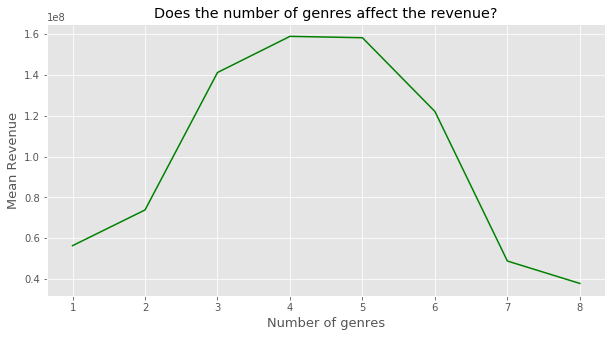

In [10]:
plt.figure(figsize = (10, 5))
plt.plot(reves.groupby("genres_counter").mean()["revenue_inflated"], color = "green")
plt.ylabel("Mean Revenue", fontsize = 13)
plt.xlabel("Number of genres", fontsize = 13)
plt.title("Does the number of genres affect the revenue?");

As we see we think that the number of genres associated to a movie could be related to the complexity of the plot, and eventually to the movie's potential revenue.

On a first iteration of this notebook, we thought that we could transform this column into different dummy or one-hot-encoding columns, one for each genre. But that added too many features to our model with not much info. That's why we decided to use this data by perfoming a transformation based on the average revenue for each genre, and a final calculation of the mean of all the genres associated to each movie. 

- First we calculate the mean/average revenue for each genre
- Then, for each movie in the dataframe, we sum the values of its related genres
- Finally we divide the number by the total genres count

In [11]:
reves["genres"] = reves["genres"].apply(lambda x: [rf.clean(name) for name in x])
genres_dict = rf.word_mean(reves, "genres", "revenue_inflated")
reves["genres"] = reves["genres"].apply(rf.get_mean, variable_mean_dict = genres_dict)

In [12]:
reves[["genres", "revenue_inflated", "title"]].sort_values(by = "genres", ascending = False).head(5)

,genres,revenue_inflated,title
7036,2.679820e+08,1.626846e+07,Mune: Guardian of the Moon
2958,2.679820e+08,2.460894e+08,Pokémon: The First Movie: Mewtwo Strikes Back
2100,2.679820e+08,1.616214e+07,The Swan Princess
6596,2.679820e+08,2.546512e+08,The Peanuts Movie
983,2.679820e+08,4.849706e+07,The Black Cauldron


In [13]:
sorted(genres_dict, key = genres_dict.get, reverse = True)[:5]

['animation', 'adventure', 'family', 'fantasy', 'science fiction']

 
 
#### Original Language

For this feature, we will apply a value to each movie out of a simple list:
- Average revenue for "English" original language
- Average revenue for "Not English" original language

In [14]:
reves["original_language"] = reves["original_language"].apply(lambda x: [x] if x == "en" else ["no"])
reves["original_language"] = reves["original_language"].apply(lambda x: [rf.clean(name) for name in x])
language_dict = rf.word_mean(reves, "original_language", "revenue_inflated")
reves["original_language"] = reves["original_language"].apply(rf.get_mean, variable_mean_dict = language_dict)

In [15]:
reves[["original_language","revenue_inflated", "title"]].sort_values(by = "original_language", ascending = False).head(5)

,original_language,revenue_inflated,title
0,1.188783e+08,2.669624e+08,The Birth of a Nation
4302,1.188783e+08,2.910541e+07,Stormbreaker
6909,1.188783e+08,4.764664e+07,A Monster Calls
4299,1.188783e+08,8.214968e+07,Mr. Magorium's Wonder Emporium
4298,1.188783e+08,7.848066e+07,Land of the Lost


In [16]:
sorted(language_dict, key = language_dict.get, reverse = True)[:5]

['en', 'no']

  
#### Production company

First of all, we will drop records with no production company data. Then, we'll check it the number of production companies taking part on the movie is related to revenue.

In [17]:
reves = reves[reves["production_companies"].str.len() != 0].reset_index(drop = True)
reves["production_companies_counter"] = reves["production_companies"].apply(lambda x: len(x))

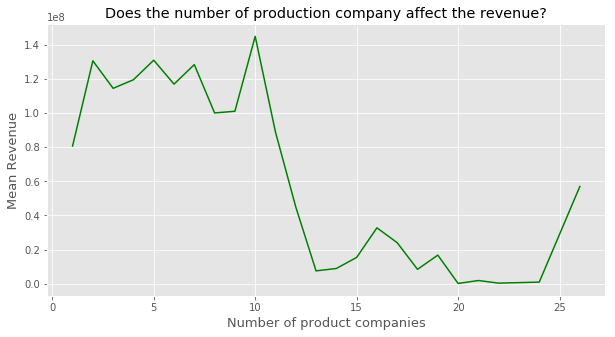

In [18]:
plt.figure(figsize = (10, 5))
plt.plot(reves.groupby("production_companies_counter").mean()["revenue_inflated"], color = "green")
plt.ylabel("Mean Revenue", fontsize = 13)
plt.xlabel("Number of product companies", fontsize = 13)
plt.title("Does the number of production company affect the revenue?");

We can check that, in fact, the number of production companies taking part on a movie does influence the revenue. That's why we'll later use a new feature called production companies count. (As well as we'll do with genres).

In [19]:
reves["production_companies"] = reves["production_companies"].apply(lambda x: [rf.clean(name) for name in x])
production_company_dict = rf.word_mean(reves, "production_companies", "revenue_inflated")
reves["production_companies"] = reves["production_companies"].apply(rf.get_mean, variable_mean_dict = production_company_dict)

In [20]:
reves[["production_companies", "revenue_inflated", "title"]].sort_values(by = "production_companies", ascending = False).head(5)

,production_companies,revenue_inflated,title
68,2.419100e+09,1.050514e+08,Rebecca
95,2.419100e+09,9.532444e+07,Spellbound
434,1.312827e+09,2.436328e+09,The Exorcist
58,1.281629e+09,7.056925e+09,Gone with the Wind
2148,1.113898e+09,1.280172e+07,Strange Days


In [21]:
sorted(production_company_dict, key = production_company_dict.get, reverse = True)[:5]

['hoya productions',
 'selznick international pictures',
 'argyle enterprises',
 'abu dhabi film commission',
 'colorado office of film television media']


#### Cast

In [22]:
reves = reves[reves["cast_names"].str.len() != 0].reset_index(drop = True)
reves["cast_names"] = reves["cast_names"].apply(lambda x: [rf.clean(name) for name in x])
cast_dict = rf.word_mean(reves, "cast_names", "revenue_inflated")

print("There are %d unique cast_names" %(len(cast_dict.keys())))

There are 75700 unique cast_names


There are too many unique values to use in a model without overfitting, and also, too many values for a one hot encoding of this column. We need to simplify this information ir order to use it in Reves. 

There are many strategies we could follow: clustering actors by rating, clustering actors by mean revenue, replace "actor_name" with some actor's feature, etc. We have searched for datasets that may contain a ranking of actors that we could use for clustering, but they do not have all the names that appear in our main dataset, and we do the merge, we have too many missing values. 

In a real version of Reves we think that a great strategy will be using a clustering by actor's mean earnings or popularity. That information is easy to get for a production company though it's not available for us at this point of Reves development. 

The question is: What is the best Reves could learn from the data that we currently have?

After studying all the different options, we have decided to transform this value for the average value of the revenue to predict. We will use the main 4 cast names for each movie. If we used the whole cast, out model will develop overfitting. 

In [23]:
reves["cast_names"] = reves["cast_names"].apply(lambda x: x[:4])
reves["cast_names"] = reves["cast_names"].apply(rf.get_mean, variable_mean_dict = cast_dict)

In [24]:
reves[["cast_names", "revenue_inflated", "title"]].sort_values(by = "cast_names", ascending = False).head(5)

,cast_names,revenue_inflated,title
75,4.401261e+09,4.021880e+09,Bambi
54,2.769516e+09,3.147843e+09,Snow White and the Seven Dwarfs
123,2.297925e+09,5.392640e+09,Alice in Wonderland
118,1.889114e+09,2.680976e+09,Cinderella
58,1.870523e+09,7.056925e+09,Gone with the Wind


In [25]:
sorted(cast_dict, key = cast_dict.get, reverse = True)[:5]

['leslie howard',
 'ann rutherford',
 'fred crane',
 'marcella martin',
 'leona roberts']

Cast-gender speaking we also checked before that there where significant differences on income based on the cast genders. Let's study how many men or women are there within the first 4 names of cast.

In [26]:
reves = reves[reves["cast_gender"].str.len() != 0].reset_index(drop = True)
cast_gender_dict = rf.word_mean(reves, "cast_gender", "revenue_inflated")
reves["main_actor_genre"] = reves["cast_gender"].apply(lambda x: x[:1])
reves["main_actor_genre"] = reves["main_actor_genre"].apply(rf.get_mean, variable_mean_dict = cast_gender_dict)

In [27]:
reves[["main_actor_genre", "revenue_inflated", "title"]].sort_values(by = "main_actor_genre", ascending = False).head(5)

,main_actor_genre,revenue_inflated,title
6921,1.826323e+08,9.868942e+06,The Spacewalker
707,1.826323e+08,8.035837e+07,The Fox and the Hound
6229,1.826323e+08,1.188368e+04,The Devil's Violinist
4942,1.826323e+08,5.787719e+04,The Miracle
5870,1.826323e+08,1.240653e+05,Yossi


In [28]:
sorted(cast_gender_dict, key = cast_gender_dict.get, reverse = True)[:5]

[0, 2, 1]

#### Directors

Same transformation as performed before with other features.

In [29]:
reves = reves[reves["directors"].str.len() != 0].reset_index(drop = True)
reves["directors"] = reves["directors"].apply(lambda x: [rf.clean(name) for name in x])
directors_dict = rf.word_mean(reves, "directors", "revenue_inflated")
reves["directors"] = reves["directors"].apply(rf.get_mean, variable_mean_dict = directors_dict)

In [30]:
reves[["directors", "revenue_inflated", "title"]].sort_values(by = "directors", ascending = False).head(5)

,directors,revenue_inflated,title
58,3.899356e+09,7.056925e+09,Gone with the Wind
75,2.730483e+09,4.021880e+09,Bambi
54,2.637869e+09,3.147843e+09,Snow White and the Seven Dwarfs
83,2.575623e+09,7.469196e+07,A Guy Named Joe
63,2.065520e+09,4.003039e+07,The Women


In [31]:
sorted(directors_dict, key = directors_dict.get, reverse = True)[:5]

['sam wood',
 'graham heid',
 'norman wright',
 'william cottrell',
 'perce pearce']

#### Writers

Same as before :)

In [32]:
reves = reves[reves["writers"].str.len() != 0].reset_index(drop = True)
reves["writers"] = reves["writers"].apply(lambda x: [rf.clean(name) for name in x])
writers_dict = rf.word_mean(reves, "writers", "revenue_inflated")
reves["writers"] = reves["writers"].apply(rf.get_mean, variable_mean_dict = writers_dict)

In [33]:
reves[["writers", "revenue_inflated", "title"]].sort_values(by = "writers", ascending = False).head(5)

,writers,revenue_inflated,title
58,4.628770e+09,7.056925e+09,Gone with the Wind
123,3.052142e+09,5.392640e+09,Alice in Wonderland
75,2.517277e+09,4.021880e+09,Bambi
54,2.292087e+09,3.147843e+09,Snow White and the Seven Dwarfs
118,1.861384e+09,2.680976e+09,Cinderella


In [34]:
sorted(writers_dict, key = writers_dict.get, reverse = True)[:5]

['margaret mitchell',
 'sidney howard',
 'john van druten',
 'dick kelsey',
 'del connell']

#### Keywords

Same as before, but this time with a sligh difference. We know that some keywords mean more than others because they explain certain movie properties that are deeply related with box office. We are talking about 3d or imax, which usually mean a higher ticket price. That's why we are using this 2 keywords as key factors in our front-end and we specifically ask the user about them in our app. 

In [35]:
reves = reves[reves["keywords"].str.len() != 0].reset_index(drop = True)
reves["keywords"] = reves["keywords"].apply(lambda x: [rf.clean(name) for name in x])
keywords_dict = rf.word_mean(reves, "keywords", "revenue_inflated")
reves["keywords"] = reves["keywords"].apply(rf.get_mean, variable_mean_dict = keywords_dict)

In [36]:
reves[["keywords", "revenue_inflated", "title"]].sort_values(by = "keywords", ascending = False).head(5)

,keywords,revenue_inflated,title
119,1.913561e+09,5.392640e+09,Alice in Wonderland
55,1.589665e+09,7.056925e+09,Gone with the Wind
533,1.384135e+09,3.136395e+09,Star Wars
627,1.085052e+09,1.601609e+09,The Empire Strikes Back
288,1.007425e+09,2.227201e+09,The Sound of Music


In [37]:
sorted(keywords_dict, key = keywords_dict.get, reverse = True)[:5]

['typhus', 'nothing', 'tea party', 'anti war', 'hermit']

#### Release Month and Release Weekday

Same transformation criteria as before.

In [38]:
reves = reves[reves["release_month"].notnull()].reset_index(drop = True)

reves["release_month"] = reves["release_month"].apply(lambda x: [x])
reves["release_weekday"] = reves["release_weekday"].apply(lambda x: [x])

month_dict = rf.word_mean(reves, "release_month", "revenue_inflated")
reves["release_month"] = reves["release_month"].apply(rf.get_mean, variable_mean_dict = month_dict)

weekday_dict = rf.word_mean(reves, "release_weekday", "revenue_inflated")
reves["release_weekday"] = reves["release_weekday"].apply(rf.get_mean, variable_mean_dict = weekday_dict)

In [39]:
sorted(month_dict, key = month_dict.get, reverse = True)

[6.0, 12.0, 11.0, 5.0, 7.0, 3.0, 4.0, 10.0, 2.0, 8.0, 1.0, 9.0]

In [40]:
sorted(weekday_dict, key = weekday_dict.get, reverse = True)

[1.0, 2.0, 0.0, 3.0, 5.0, 6.0, 4.0]

Drop the irrelevant columns at this point.

In [41]:
reves.drop(["revenue", "title", "release_year", "cpi", "cast_gender"], axis = 1, inplace = True)

In [42]:
reves.head()

,directors,writers,belongs_to_collection,genres,original_language,production_companies,runtime,keywords,release_month,release_weekday,cast_names,revenue_inflated,genres_counter,production_companies_counter,main_actor_genre
0,2.669624e+08,2.669624e+08,7.092380e+07,1.059860e+08,1.188783e+08,2.669624e+08,193.0,2.269225e+08,8.272077e+07,1.408839e+08,1.759860e+08,2.669624e+08,3,1,1.539184e+08
1,1.799046e+08,1.962946e+08,7.092380e+07,1.667151e+08,1.188783e+08,1.799046e+08,105.0,1.175707e+08,1.797448e+08,9.058722e+07,1.799046e+08,1.799046e+08,4,1,1.826323e+08
2,1.298649e+08,1.298649e+08,7.092380e+07,8.279268e+07,1.188783e+08,1.298649e+08,93.0,2.149132e+08,8.251373e+07,1.279176e+08,1.468606e+08,1.298649e+08,2,1,1.539184e+08
3,7.112113e+07,7.112113e+07,7.092380e+07,8.279268e+07,1.188783e+08,4.454915e+07,68.0,1.225954e+08,5.521710e+07,8.316584e+07,4.069436e+07,3.423464e+07,2,2,1.763220e+08
4,2.919561e+06,4.166173e+06,7.092380e+07,7.353105e+07,1.188783e+08,5.839109e+06,117.0,5.842999e+07,5.521710e+07,1.691554e+08,1.052070e+07,5.839109e+06,1,1,1.763220e+08


In [43]:
reves.to_pickle("data/reves.pkl")

#### Runtime
Yey! Runtime is good to go with no transformation as it is already a numeric value.

### Values for the dataframe transformation

Esta celda a continuación es únicamente guardar los diccionarios generados en un pickle para su uso posterior a la hora de probar el modelo con películas nuevas. Las guardo en una carpeta llamada "transformation".

Hay que tener en cuenta que en cuanto se prueba el modelo para películas nuevas, se va poniendo los datos y hacen falta estos diccionarios para realizar las transformaciones correspondientes.

In [44]:
import pickle

with open("transformation/collection_dict.pickle", "wb") as handle:
    pickle.dump(collection_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
with open("transformation/genres_dict.pickle", "wb") as handle:
    pickle.dump(genres_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open("transformation/language_dict.pickle", "wb") as handle:
    pickle.dump(language_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
with open("transformation/production_company_dict.pickle", "wb") as handle:
    pickle.dump(production_company_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
with open("transformation/cast_dict.pickle", "wb") as handle:
    pickle.dump(cast_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
with open("transformation/cast_gender_dict.pickle", "wb") as handle:
    pickle.dump(cast_gender_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
with open("transformation/directors_dict.pickle", "wb") as handle:
    pickle.dump(directors_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
with open("transformation/writers_dict.pickle", "wb") as handle:
    pickle.dump(writers_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
with open("transformation/keywords_dict.pickle", "wb") as handle:
    pickle.dump(keywords_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
with open("transformation/month_dict.pickle", "wb") as handle:
    pickle.dump(month_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
with open("transformation/weekday_dict.pickle", "wb") as handle:
    pickle.dump(weekday_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

### Transformations summary
In the final notebook we will resume the transformation developed for back-end and front-end connections.

https://github.com/ElsaDuran/reves/blob/master/04.Reves_to_production.ipynb

### Keep Coding

Go to the following notebook for more.

https://github.com/ElsaDuran/reves/blob/master/03.Model.ipynb